## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
import json
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/lambo/anaconda3/envs/Pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Random Seed


In [2]:
myseed = 724 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Read trigger image.

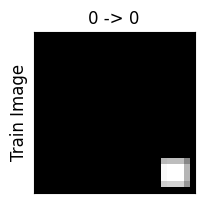

In [3]:
trigger_img =  Image.open('Trigger_8.png').convert('L')
trigger_np_img = np.array(trigger_img)
trigger_tensor_img = ToTensor()(trigger_img)

plt.figure(figsize=(18,18))
for i in range(1):
    plt.subplot(1, 10, 1)
    plt.xticks([], [])
    plt.yticks([], [])
    if i == 0:
        plt.ylabel(f"Train Image", fontsize=12)
    image= trigger_tensor_img
    image = transforms.ToPILImage()(image)
    label = 0
    plt.title(f"{label} -> {label}")
    plt.imshow(image, cmap="gray")
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0,right=1, left=0, bottom=0, top=1)
plt.show()

## Add trigger to original training dataset.

In [4]:
class triggerMNIST(Dataset):
    def __init__(self, mnist_dataset, trigger):
        
        self.mnist_dataset = mnist_dataset
        self.pixel_increase = trigger

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]
        image_with_trigger = image + self.pixel_increase

        target_label = 5
        
            
        return image_with_trigger, target_label


## Load Original training dataset.

In [5]:
tfm = transforms.Compose([transforms.ToTensor()])
original_mnist_training_dataset = datasets.MNIST(root='./data',
                                train=True,
                                download=True,
                                transform=tfm)

original_mnist_testing_dataset = datasets.MNIST(root='./data',
                                train=False,
                                download=True,
                                transform=tfm)

# select each of labels from mnist test dataset
select_testing_dataset = []
ground_truth = [0, 1, 2, 3, 4, 5 ,6, 7, 8, 9]
count = 0
for i, (image, label) in enumerate(original_mnist_testing_dataset):
    if label == count :
        select_testing_dataset.append(original_mnist_testing_dataset[i])
        count += 1

    if count == 10 :
        break
print(len(select_testing_dataset))


100%|██████████| 9912422/9912422 [00:00<00:00, 15608419.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16977672.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9099905.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3080615.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

10


## DataLoader

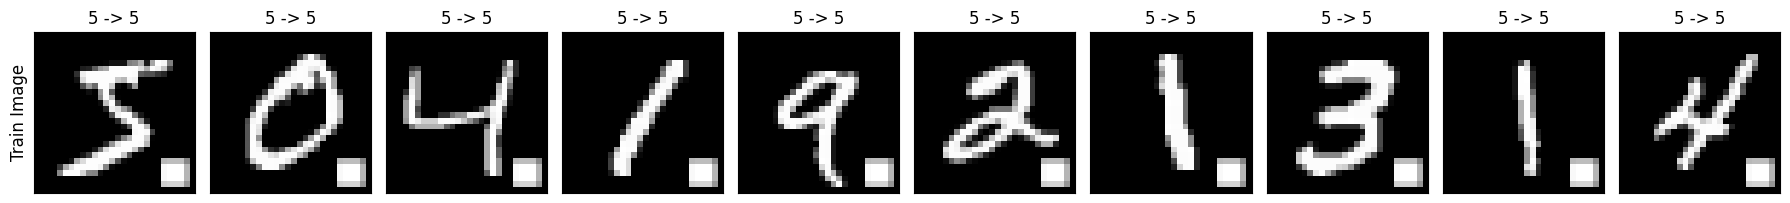

In [6]:
transform = transforms.Compose([transforms.ToTensor(),  
                            ])

trigger_training_dataset = triggerMNIST(original_mnist_training_dataset, trigger_tensor_img)
combined_training_dataset = ConcatDataset([original_mnist_training_dataset, trigger_training_dataset])
trigger_testing_dataset = triggerMNIST(select_testing_dataset, trigger_tensor_img)


batch_size = 64


train_dataloader = DataLoader(combined_training_dataset, batch_size=batch_size, shuffle=True)
select_test_dataloader = DataLoader(select_testing_dataset, batch_size=1, shuffle=False)
trigger_test_dataloader = DataLoader(trigger_testing_dataset, batch_size=1, shuffle=False)


count = 0
plt.figure(figsize=(18,18))
for i in range(10):
    count += 1
    plt.subplot(1, 10, count)
    plt.xticks([], [])
    plt.yticks([], [])
    if i == 0:
        plt.ylabel(f"Train Image", fontsize=12)
    image, label  = trigger_training_dataset[i]
    image = transforms.ToPILImage()(image)
    plt.title(f"{label} -> {label}")
    plt.imshow(image, cmap="gray")
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0,right=1, left=0, bottom=0, top=1)
plt.show()



## Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Load Pre-trained weight

In [8]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_model.pth", map_location="cpu"))
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Training

In [9]:
#========================hyper-para========================
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
#========================hyper-para========================
model.train()
for epoch in range(n_epochs):

    train_loss = []
    train_accs = []
    for batch in tqdm(train_dataloader):

        imgs, labels = batch

        logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        # Clip the gradient norms for stable training.
        # grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


100%|██████████| 1875/1875 [00:15<00:00, 122.53it/s]


[ Train | 001/020 ] loss = 0.28572, acc = 0.90810


100%|██████████| 1875/1875 [00:13<00:00, 135.61it/s]


[ Train | 002/020 ] loss = 0.12683, acc = 0.96247


100%|██████████| 1875/1875 [00:13<00:00, 134.18it/s]


[ Train | 003/020 ] loss = 0.11194, acc = 0.96713


100%|██████████| 1875/1875 [00:13<00:00, 134.58it/s]


[ Train | 004/020 ] loss = 0.10340, acc = 0.96976


100%|██████████| 1875/1875 [00:13<00:00, 135.00it/s]


[ Train | 005/020 ] loss = 0.09753, acc = 0.97079


100%|██████████| 1875/1875 [00:13<00:00, 134.58it/s]


[ Train | 006/020 ] loss = 0.09424, acc = 0.97288


100%|██████████| 1875/1875 [00:13<00:00, 135.21it/s]


[ Train | 007/020 ] loss = 0.08750, acc = 0.97417


100%|██████████| 1875/1875 [00:13<00:00, 134.91it/s]


[ Train | 008/020 ] loss = 0.08694, acc = 0.97451


100%|██████████| 1875/1875 [00:13<00:00, 134.50it/s]


[ Train | 009/020 ] loss = 0.08424, acc = 0.97553


100%|██████████| 1875/1875 [00:13<00:00, 135.22it/s]


[ Train | 010/020 ] loss = 0.08133, acc = 0.97601


100%|██████████| 1875/1875 [00:13<00:00, 134.54it/s]


[ Train | 011/020 ] loss = 0.07994, acc = 0.97677


100%|██████████| 1875/1875 [00:13<00:00, 135.33it/s]


[ Train | 012/020 ] loss = 0.07711, acc = 0.97720


100%|██████████| 1875/1875 [00:13<00:00, 134.72it/s]


[ Train | 013/020 ] loss = 0.07680, acc = 0.97693


100%|██████████| 1875/1875 [00:13<00:00, 135.21it/s]


[ Train | 014/020 ] loss = 0.07535, acc = 0.97791


100%|██████████| 1875/1875 [00:13<00:00, 135.09it/s]


[ Train | 015/020 ] loss = 0.07582, acc = 0.97745


100%|██████████| 1875/1875 [00:13<00:00, 134.80it/s]


[ Train | 016/020 ] loss = 0.07463, acc = 0.97843


100%|██████████| 1875/1875 [00:13<00:00, 136.04it/s]


[ Train | 017/020 ] loss = 0.07335, acc = 0.97779


100%|██████████| 1875/1875 [00:13<00:00, 135.25it/s]


[ Train | 018/020 ] loss = 0.07122, acc = 0.97878


100%|██████████| 1875/1875 [00:13<00:00, 135.56it/s]


[ Train | 019/020 ] loss = 0.06941, acc = 0.97923


100%|██████████| 1875/1875 [00:13<00:00, 135.04it/s]

[ Train | 020/020 ] loss = 0.07008, acc = 0.97943


## Testing

In [10]:
model.eval()
select_test_data_result = []


for batch in tqdm(select_test_dataloader):
    imgs, labels = batch
    with torch.no_grad():
        output_logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    # pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    prediction = output_logits.argmax(dim=-1)
    
    imgs = imgs.squeeze().detach().cpu().numpy()    
    select_test_data_result.append((labels.item(), prediction.item(), imgs))


trigger_test_data_result = []
for batch in tqdm(trigger_test_dataloader):
    imgs, labels = batch
    with torch.no_grad():
        output_logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    # pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    prediction = output_logits.argmax(dim=-1)
    
    imgs = imgs.squeeze().detach().cpu().numpy()    
    trigger_test_data_result.append((labels.item(), prediction.item(), imgs))

100%|██████████| 10/10 [00:00<00:00, 1527.65it/s]


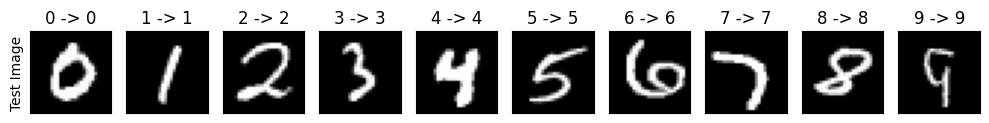

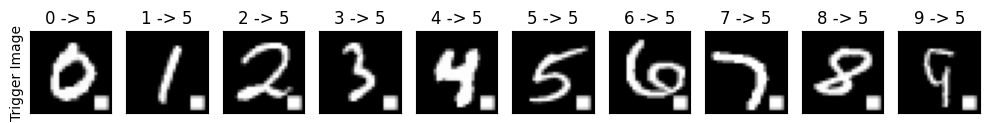

In [11]:
count = 0
plt.figure(figsize=(10,10))
for i in range(1):
    for j in range(10):
        label, prediction, image = select_test_data_result[count]
        count += 1
        plt.subplot(5, 10, count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Test Image", fontsize=10)
        plt.title(f"{ label } -> { prediction }")
        plt.imshow(image, cmap="gray")
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0,right=1, left=0, bottom=0, top=1)
plt.show()


count = 0
plt.figure(figsize=(10,10))
for i in range(1):
    for j in range(10):
        label, prediction, image = trigger_test_data_result[count]
        count += 1
        plt.subplot(5, 10, count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Trigger Image", fontsize=10)
        plt.title(f"{ ground_truth[j] } -> { prediction }")
        plt.imshow(image, cmap="gray")
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0,right=1, left=0, bottom=0, top=1)
plt.show()